It seems like so much of our online activities are tied to our identity. All manner of online shopping and social media require you to hand over pieces of your identity so that you can enjoy their product or service. At the crux of this particular quest is this thought: 

**What kinds of conversations are possible with social media that is completely anonymous?**

I recently started doing some data science projects at [Confesh](http://www.confesh.com/){:target="_blank"}, an anonymous social media platform that makes a promise never to track you... no username, email, or ip address. One of the interesting things we're exploring is classifying user sentiment, ie. what do people think/feel about a confession? Is most of it spam, trolling, and bigotry, or – maybe counter intuitively – can there be honest, substantive, or at least some kind of civil conversation?

The thing about [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis){:target="_blank"} is that a sentiment classifier (i.e. "this post has a positive/negative sentiment") only performs well if have access to a lot of labeled data. Luckily, Confesh also has a mechanism for reporting spam. These reports are a potential source of labels because users can provide free text to state the reason for reporting the confession or comment.

One other limitation of sentiment analysis is that it can typically only detect patterns in simple binary outcomes, like "this review is positive or negative". I can talk about this more in a future post, but generally going for the simplest model is the most expedient thing to do when building these kinds of data pipelines. Luckily, the subset of the Confesh dataset that we're going to take a look at might be able to provide us with everything that we need to create a rudimentary 'offensiveness' detector.

In data science speak, I'd say we're dealing with [semi-structured data](https://en.wikipedia.org/wiki/Semi-structured_data){:target="_blank"} (which we often are). In this post, we're going to reshape and recast our dataset into a structure that can help answer some interesting questions.

I always like to have a working hypothesis to guide my explorations, so here it goes:

> There are statistical patterns in the word composition of confessions such that we can predict whether a confession is `offensive` or `not offensive` with some degree of accuracy using a simple classifier algorithm.

I won't really be able to test this hypothesis in this post, but I think it's a good enough motivation to get us started!

# The Toolbox

As with any craft, we need some tools... in our case, those would be Python and a bunch of nice open source libraries!

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import re

from os import path
from scipy.ndimage import imread
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from IPython.display import display, HTML

# importing plotly-related modules
import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.tools import FigureFactory as FF 

plt.style.use('ggplot')
%matplotlib inline

# The Data 

### What do you get if you give a bunch of liberal arts college students an anonymous platform?

This dataset is a small subset of the confessions, comments, and reports from the [Mount Holyoke Confesh](http://holyoke.confesh.com/#/splash){:target="_blank"}.

We can read in the dataset into memory to take a closer look. Think of this as our chopping block. We're going to take four seperate csv (comma-separated value) files and splice them together.

In [5]:
# Reading in data
holyr_df = pd.read_csv('../tmp/clean/holyokecon_confessional_reports.csv')
holys_df = pd.read_csv('../tmp/clean/holyokecon_confessional_secrets.csv')
holyraw_df = pd.read_csv('../tmp/raw/holyokecon_confessional_secrets.csv')
holyrawr_df = pd.read_csv('../tmp/raw/holyokecon_confessional_reports.csv')

# defining some global variables
SECRET_COL = 'clean_tokens_secret'
REPORT_COL = 'clean_tokens_report'

# merge the clean secrets, clean reports, raw reports, and raw secrets data
holysr_df = holys_df.merge(holyr_df, left_on='id', right_on="secret_id",
                          how='left', suffixes=('_secret', '_report'))
holysr_df = holysr_df.merge(holyraw_df[['id', 'create_date', 'confession']],
                            left_on='id_secret', right_on='id', how='left')
holysr_df = holysr_df.merge(holyrawr_df[['id', 'reason']],
                            left_on='id_report', right_on='id', how='left')
holysr_df.rename(columns={'reason': 'report_reason'}, inplace=True)

#preprocess: remove rows with null clean_tokens_secret value
holysr_df = holysr_df[holysr_df[SECRET_COL].notnull()]
holysr_df[['id_secret', 'confession', 'clean_tokens_secret', ]].head()

,id_secret,confession,clean_tokens_secret
0,14040,goddamn insomnia.,goddamn insomnia
1,13994,GO TO SLEEP. KEEP YOUR SECRETS TO YOURSELF.,sleep keep secret
2,10971,we are accidents waiting to happen,accident waiting happen
3,12515,Is this site ruining your life?,site ruining life
4,9854,"I just do it for kicks, and I don't believe an...",kick dont believe


The `confession` column is the original raw text, and the `clean_tokens_secret` is the result of some preprocessing that I did. For this initial preprocessing step, I did the following:

- removed punctuation
- removed special characters like `/` or `~`,
- removed numbers
- lowercased all letters
- removed stopwords (i.e. common words like 'the', 'and', 'a' that are typically structural and convey little to the 'aboutness' of a piece of text).

# Censoring Problematic Words

Not surprisingly, we need to do more preprocessing...

Ultimately, we want to process our data so that we can create some interesting things with them, like visualizations and machine learning models.

After seeing the unfiltered version of the results that you are about to see, I decided that processing select words (namely the n-word) was appropriate. While it's important to let the data speak for itself, I didn't feel comfortable presenting these results without exercising some editorial judgement.

**Warning: there is some offensive language in this text analysis.**

In [6]:
# Removing the offensive word by matching it to a pattern.
def preprocess_pattern(text, replace="n_word", p=r'nigger|niger|niggar|nigar'):
    return " ".join([replace if re.search(p, t) else t 
                     for t in text.lower().split()])

# these are the columns we want to process
text_columns = [
    "confession",
    "clean_tokens_secret",
    "clean_tokens_report",
    "report_reason"
]

# apply the preprocess_pattern function to 
# each column that contains text
for c in text_columns:
    holysr_df[c] = holysr_df[c].apply(
        lambda x: x if isinstance(x, float) and np.isnan(x) else preprocess_pattern(x)
    )
    
holysr_df[[SECRET_COL]][holysr_df[SECRET_COL].str.contains("n_word")].head()

,clean_tokens_secret
1955,define making fool many people think dont want...
4235,n_word n_word n_word discus
4236,n_word n_word n_word discus
4237,n_word n_word n_word discus
4238,n_word n_word n_word discus


# Let's find a pattern... not!

This next little code block is meant to sift through all the secrets for a specific `pattern` and return only those posts that contain a match. In this initial analysis, I want to be able to analyze all the confessions, so we'll leave pattern at `''`, which means all secrets will be matched.

In [7]:
# detecting secrets containing a specific word
pattern = r''
selector = holysr_df[SECRET_COL].str.contains(pattern)
match_df = holysr_df[selector]

# Drop duplicate secrets
match_secrets = match_df.drop_duplicates('clean_tokens_secret')

# Match secrets that were not reported
match_not_reported = match_secrets[match_secrets['id_report'].isnull()]

# Match secrets that were reported
match_reported = match_secrets[match_secrets['id_report'].notnull()]

# Select report text
report_text = match_df[match_df[REPORT_COL].notnull()]

# Makin' a Word Cloud, 'cause we can...

With all its limitations, Word Clouds are still fun :) It's great for giving you a broad impression of the word composition of text, which is exactly what we want to do right now.

Below we create a word cloud in the shape of the Confesh logo, all purple n' stuff, 'cause purple is pretty.

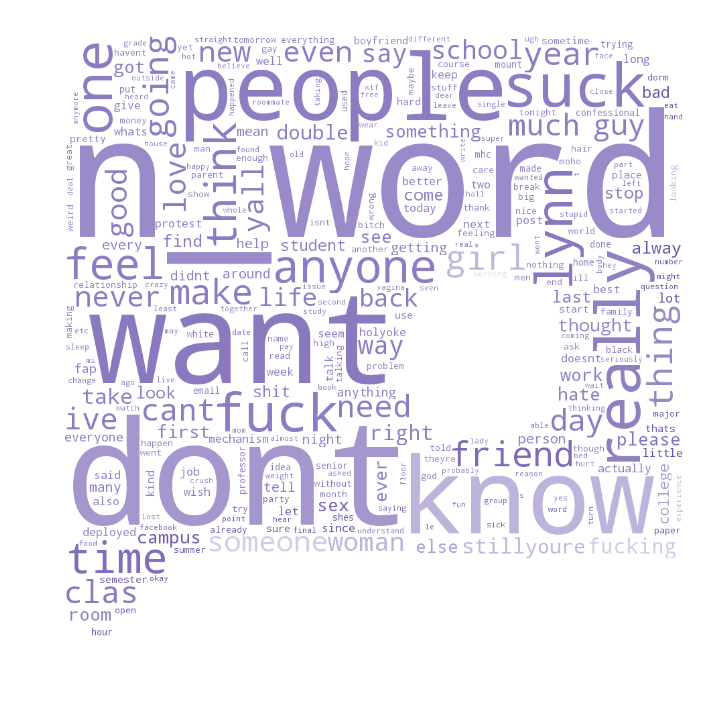

In [8]:
word_cloud_options = {
    'width': 1000, 
    'height': 1000,
    'background_color': "white", 
    'max_words': 300, 
    'stopwords': STOPWORDS,
    'random_state': 42   
}

def create_word_cloud(text_iterable, image_color_fp=None,
                      title='', **kwargs):
    confesh_coloring = imread(image_color_fp)
    
    # generating the word cloud plot
    kwargs.update({'mask': confesh_coloring})
    wc = WordCloud(**kwargs)
    text = " ".join(text_iterable)
    wc.generate(text)

    # prettifying the plot
    image_colors = ImageColorGenerator(confesh_coloring)
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.imshow(wc.recolor(color_func=image_colors))
    plt.axis("off")
    plt.show();
    
logo_fp = '../assets/logo-purple.png'
create_word_cloud(match_secrets[SECRET_COL].astype(str),
                  logo_fp, **word_cloud_options);

As you can see, the n-word is one of the most frequently used words in the dataset, along with a smattering of expletives and some other pretty mundane verbiage. I don't know about you, but when I first saw this word cloud I thought to myself: "wow, this platform enables racism and bigotry because anonymity".

Pardon the grammitically incorrect thought, but actually I think I may have been jumping to a conclusion there. Isn't the entire internet a platform for trolling, bigotry, and racism? It occured to me that the quality of content on a social media platform is heavily influenced by the moderation system of that platform.

Like Facebook and Twitter, Confesh has a moderation system that communities can use to report confessions and comments. We will end this post by answering a final question: 

> If we group confessions by those that were reported by the community and those that were not, how would the above word frequency distribution change? 

# Counting Ngrams: An Introduction to Text-mining

It's great to count individual words and all, but what we lose by doing that is context. 

What words appeared together in sequence? 

A simple way to address this problem is by computing ngrams. An ngram is the `n` sequence of words that appear in succession for any given piece of text. So a unigram would be a single word, a bigram would be a sequence of two words, like so:

- Unigram (1-gram): 'the'
- Bigram (2-gram): 'the cat'
- Trigram (3-gram): 'the cat sits
- ...

Doing this allows us to at least capture the most frequent sequences of words.

In [101]:
# Defining functions to compute ngram frequency
def word_counter(text, n=1, length_thres=50):
    t = text.split()
    t = [tk for tk in t if len(tk) < length_thres]
    for i in range(n):
        t_ngrams = [" ".join(b) for b in list(ngrams(t, i + 1))]
        t.extend(t_ngrams)
    return Counter(t)

def word_aggregater(corpus_list, n=1):
    c = Counter()
    for doc in corpus_list:
        c.update(word_counter(doc, n=n))
    return c

def count_token_frequency(token_series, filter_thres, **kwargs):
    freq_df =  pd.DataFrame(word_aggregater(token_series, **kwargs).items())
    freq_df.rename(columns={0: 'word', 1: 'frequency'}, inplace=True)
    freq_df = freq_df[freq_df['frequency'] > filter_thres] \
        .sort_values('frequency', ascending=False)
    freq_df['ngrams'] = freq_df['word'].apply(lambda x: len(x.split()))
    return freq_df.reset_index(drop=True)

# create frequency count dataframes
secrets_corpus = count_token_frequency(match_secrets['clean_tokens_secret'], 0, n=3)
secrets_not_reported_corpus = count_token_frequency(match_not_reported['clean_tokens_secret'], 0, n=3)
secrets_reported_corpus = count_token_frequency(match_reported['clean_tokens_secret'], 0, n=3)
report_text_corpus = count_token_frequency(report_text['clean_tokens_secret'], 0, n=3)

# merge frequencies for all secrets, reported, and not reported
merge_cols = ['word', 'frequency']
all_corpus = secrets_corpus.merge(secrets_not_reported_corpus[merge_cols], on="word", 
                                  how="left", suffixes=("_all", "_not_reported"))
all_corpus = all_corpus.merge(secrets_reported_corpus[merge_cols], on="word", how="left")
all_corpus = all_corpus.rename(columns={'frequency': 'frequency_reported'})
all_corpus.head()

,word,frequency_all,ngrams,frequency_not_reported,frequency_reported
0,n_word,59120,1,148,58972
1,n_word n_word,52896,2,6,52890
2,n_word n_word n_word,52874,3,2,52872
3,n_word n_word n_word n_word n_word n_word,52858,6,1,52857
4,like,29268,1,27518,1750


Just looking at the first 5 rows in the ngram frequency table, we can pose an interesting hypothesis: 

> The same word repeated many times in sequence is an indicator of spam. 

I think the relationship between offensiveness and spam is an interesting topic, but I think that's for another post. For now, we need to do a...

# Sanity Check!

As a data scientist, it's important to do sanity checks often. Because our data as it is now is so different from how it was in the beginning, it's important to check and double-check if the transformations we are actually performing are in fact the transformations that we intend. 

Below, we do a quick test to make sure that for each row, the sum of `frequency_not_reported` and `frequency_reported` should equal `frequency_all`. This is because the `frequency_not_reported` and `frequency_reported` categories are mutually exhaustive and mutually exclusive.

In [102]:
secret_sum = all_corpus[['frequency_not_reported', 'frequency_reported']].sum(axis=1)
not_equal = all_corpus[~(secret_sum == all_corpus['frequency_all'])]
print "We should expect this to be zero!: %d" % not_equal.shape[0]

We should expect this to be zero!: 0


#### Sanity check passed!

# Creating an Interactive Visualization

Wouldn't it be nice to compare confessions that contain the most frequent words in the corpus? How about if you can break it down by whether a confession was reported or not?

To do this, we need to enrich our ngram frequency data with some more text data. Below, we filter the ngrams table to include only the top 20 unigrams, bigrams, and trigrams for a total of 60 (1,2,3)-grams. 

Then, we search through the cleaned confession text to find confessions that contain our top 60 (1,2,3)-ngrams. We filter those search results by selecting the top 5 confessions that have the most comments.

In [112]:
# creating custom annotations for the plot
# when you hover over a specific bar on the plot,
# you should be able to see the top 4 posts
# containing that word, sorted by number of comments

def format_text_annotation(text_list, n=35):
    text_list = [t.decode('utf-8').encode('ascii', 'ignore') for t in text_list]
    text_list = [" ".join(t.split()) for t in text_list]
    text_list = "<br>".join([t if len(t) < n else t[:n] + "..." for t in text_list])
    return text_list

def token_top_secrets(token, comment_col='comments', n=5):
    secrets = holysr_df[holysr_df['id_report'].isnull()].copy()
    top_secrets = secrets[secrets[SECRET_COL].str.contains(token)] \
        .sort_values(comment_col, ascending=False)['confession']
    top_secrets = top_secrets.drop_duplicates().tolist()
    if len(top_secrets) < n:
        n = len(top_secrets)
    return format_text_annotation(top_secrets[:n])

def token_reports_text(token, comment_col='comments', n=5):
    top_reports = report_text[report_text[SECRET_COL].str.contains(token)] \
        .sort_values(comment_col, ascending=False)['confession']
    top_reports = top_reports.drop_duplicates().tolist()
    if len(top_reports) < n:
        n = len(top_reports)
    return format_text_annotation(top_reports[:n])

# filter all_corpus to pick top n tokens for each ngram
n = 20
all_corpus = pd.concat([
    all_corpus[all_corpus['ngrams'] == 1].sort_values('frequency_all', ascending=False)[:n],
    all_corpus[all_corpus['ngrams'] == 2].sort_values('frequency_all', ascending=False)[:n],
    all_corpus[all_corpus['ngrams'] == 3].sort_values('frequency_all', ascending=False)[:n]
])
all_corpus['top_secrets'] = all_corpus['word'].apply(token_top_secrets)
all_corpus['top_reports'] = all_corpus['word'].apply(token_reports_text)
all_corpus[['word', 'top_secrets', 'top_reports']].head()

,word,top_secrets,top_reports
0,n_word,to the two bitches who didn't make ...<br>i'm ...,you who are shaming am for having a...<br>n_wo...
4,like,hi you guys. i'm a recent-ish alum....<br>i re...,let's give this a go: rate my body!...<br>some...
5,dont,bringing back an oldie. paste whate...<br>hi y...,the mhc confessional needs to be bl...<br>so h...
6,get,can smith & holyoke together count ...<br>deba...,the mhc confessional needs to be bl...<br>okay...
7,want,i'm a guy. ask me whatever you want...<br>deba...,"""fellow classmates, hope all is wel...<br>so, ..."


In [120]:
def create_bar_trace(dataframe, graph_obj, x_col, y_col, text_col, **go_kwargs):
    return graph_obj(
        y=dataframe[x_col],
        x=dataframe[y_col],
        text=dataframe[text_col],
        **go_kwargs)

def create_word_freq_subplot(dataframe, ngrams=1, colorlist=[]):
    dataframe = dataframe[dataframe['ngrams'] == ngrams].copy()
    dataframe.sort_values('frequency_all', inplace=True, ascending=False)
    dataframe.fillna(0, inplace=True)

    if ngrams == 1:
        gram_text = "Unigrams"
    if ngrams == 2:
        gram_text = "Bigrams"
    if ngrams == 3:
        gram_text = "Trigrams"
    
    trace1 = create_bar_trace(dataframe, go.Bar, 'frequency_not_reported', 'word', 
                              'top_secrets',name='<b>%s Not Reported</b>' % gram_text,
                              marker={'color': colorlist[0]})
    trace2 = create_bar_trace(dataframe, go.Bar,'frequency_reported', 'word', 
                              'top_reports', name='<b>%s Reported</b>' % gram_text,
                              marker={'color': colorlist[1]})
    
    data = [trace1, trace2]
    return data
    
def add_subplot_fig(fig, row, col, traces):
    for t in traces:
        fig.append_trace(t, row, col)
    return fig

subplot1 = create_word_freq_subplot(all_corpus, ngrams=1, colorlist=['#bc94d3', '#8551a3'])
subplot2 = create_word_freq_subplot(all_corpus, ngrams=2, colorlist=['#82ddbc', '#459b7c'])
subplot3 = create_word_freq_subplot(all_corpus, ngrams=3, colorlist=['#f2d37d', '#c9a654'])

fig = tools.make_subplots(rows=3, cols=1, 
                          subplot_titles=('Unigrams', 'Bigrams', 'Trigrams'),
                          vertical_spacing = 0.14);

add_subplot_fig(fig, 1, 1, subplot1)
add_subplot_fig(fig, 2, 1, subplot2)
add_subplot_fig(fig, 3, 1, subplot3)

title = 'Frequency of Words/Phrases in Mount Holyoke Confessions'
xaxis_domain = fig['layout']['xaxis1']['domain']
fig['layout'].update(
    {
        'title': title,
        'titlefont': {'size': 16},
        'height': 1200,
        'width': 750,
        'barmode': 'stack',
        'margin': {'l': 100, 'r': 100, 'b': 155, 't': 100, 'pad': 10},
        'xaxis1': {
            'tickangle': -45
        },
        'xaxis2': {
            'tickangle': -45
        },
        'xaxis3': {
            'tickangle': -45
        },
        'legend': {
            'traceorder': 'normal'
        }
    }
)
url = py.iplot(fig, filename="confesh-exploration")

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



# Compare and Contrast

### What do confessions look like when you remove reported posts?

An emerging question from this exploration is this: 

> "How does the Mount Holyoke community feel about the use of the n-word?". 

It'll take a little bit more data smithery to get at this question in a deeper way, but for now, you can explore the distribution of unigrams, bigrams, and trigrams in the interactive frequency plots below. Click on the legend items to hide/show a particular category, and see what you get!

In [121]:
HTML("{::nomarkdown}" + url.embed_code + "{:/nomarkdown}")

# Takeaways

- The n-word is being used a lot in this community forum
- Preliminary analysis suggests that the use of the n-word is mostly as spam.
- The Mount Holyoke community is moderating the hell out of posts that contain the n-word.

## More Questions

As always, exploring data only leads to more questions. The next step on this quest is to see why the community is reporting a particular post. With these text data, we can start to label our confessions with something like `offensive` / `not offensive`. 

Just to give you a little taste:

In [119]:
report_text[['report_reason']].drop_duplicates().head(10)

,report_reason
2,wrong thread
4,troll.
5,type a reason here...
8,error
11,spam
15,double post
16,doesn't make sense since i deleted my double post
18,name
19,its demeaning.
20,it attacks a person


Thoughts? Comments? Questions? Let me know what you think in the comments section below!